In [14]:
# library
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score


from torchmetrics import R2Score
r2score = R2Score()

torch.manual_seed(1)
np.random.seed(1)
torch.set_printoptions(precision=3)

import warnings
warnings.filterwarnings("ignore")

In [15]:
class MonotonicLinear(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    self.input_size  = input_size
    self.output_size = output_size
    self.weights = torch.nn.Parameter(torch.rand((output_size, input_size), dtype=torch.float32))

  def forward(self, x):
    z = torch.mm(x, torch.exp(self.weights.t()))
    return z

In [16]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.input1 = MonotonicLinear(1, 3)
    self.input2 = torch.nn.Linear(1, 3)
    self.input3 = torch.nn.Linear(1, 3)
    self.output = torch.nn.MaxPool1d(3)

  def forward(self, x_m, x_u1, x_u2):
    z1 = self.input1(x_m)
    z2 = self.input2(x_u1)
    z3 = self.input3(x_u2)
    z  = torch.add(torch.add(z1, z2), z3)
    z  = self.output(z)
    return z

In [17]:
# Model error
def eval(model, testset):
    with torch.no_grad():
        pred_Y1 = model(testset.x_m_data, testset.x_u1_data, testset.x_u2_data)
        pred_Y2 = model(testset.x_m1_data, pred_Y1, testset.x_u21_data)
        pred_Y3 = model(testset.x_m2_data, pred_Y2, testset.x_u22_data)
        pred_Y4 = model(testset.x_m3_data, pred_Y3, testset.x_u23_data)

    return r2score(pred_Y1, testset.y1_data).item(), r2score(pred_Y2, testset.y2_data).item(), r2score(pred_Y3, testset.y3_data).item(), r2score(pred_Y4, testset.y4_data).item()

In [18]:
def func_test_R2(model, Tz_0, Tz_1, Tsa_1, msa_1, steps):
    Tz0  =  Tz_0[0].reshape(-1,1)
    T = np.array([])
    for i in range(steps):
        with torch.no_grad():
            # COMPUTE
            x1 = torch.tensor(np.copy(Tsa_1[i]).reshape(-1,1), dtype=torch.float32)
            x2 = torch.tensor(Tz0, dtype=torch.float32)
            x3 = torch.tensor(np.copy(msa_1[i]).reshape(-1,1), dtype=torch.float32)
            Tz1 = model(x1, x2, x3)

            # UPDATE
            Tz0 = np.copy(Tz1).reshape(-1,1)

            # save Tz
            T = np.append(T, Tz1)
    return r2_score(Tz_1[0:steps, 0], T)

In [19]:
# Data
class Data(torch.utils.data.Dataset):
  def __init__(self, src_file, start=None, end=None):
    df = pd.read_csv(src_file)
    Tsa_k1 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+1: end+1]
    Tsa_k2 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+2: end+2]
    Tsa_k3 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+3: end+3]
    Tsa_k4 = np.array(df['supply_discharge_temp']).reshape(-1,1)[start+4: end+4]
    Tz_k   = np.array(df['room_temp']).reshape(-1,1)[start: end]
    Tz_k1  = np.array(df['room_temp']).reshape(-1,1)[start+1: end+1]
    Tz_k2  = np.array(df['room_temp']).reshape(-1,1)[start+2: end+2]
    Tz_k3  = np.array(df['room_temp']).reshape(-1,1)[start+3: end+3]
    Tz_k4  = np.array(df['room_temp']).reshape(-1,1)[start+4: end+4]
    msa_k1 = np.array(df['airflow_current']).reshape(-1,1)[start+1: end+1]
    msa_k2 = np.array(df['airflow_current']).reshape(-1,1)[start+2: end+2]
    msa_k3 = np.array(df['airflow_current']).reshape(-1,1)[start+3: end+3]
    msa_k4 = np.array(df['airflow_current']).reshape(-1,1)[start+4: end+4]

    self.x_m_data   = torch.tensor(Tsa_k1, dtype=torch.float32)
    self.x_m1_data  = torch.tensor(Tsa_k2, dtype=torch.float32)
    self.x_m2_data  = torch.tensor(Tsa_k3, dtype=torch.float32)
    self.x_m3_data  = torch.tensor(Tsa_k4, dtype=torch.float32)
    self.x_u1_data  = torch.tensor(Tz_k, dtype=torch.float32)
    self.x_u2_data  = torch.tensor(msa_k1, dtype=torch.float32)
    self.x_u21_data = torch.tensor(msa_k2, dtype=torch.float32)
    self.x_u22_data = torch.tensor(msa_k3, dtype=torch.float32)
    self.x_u23_data = torch.tensor(msa_k4, dtype=torch.float32)
    self.y1_data    = torch.tensor(Tz_k1, dtype=torch.float32)
    self.y2_data    = torch.tensor(Tz_k2, dtype=torch.float32)
    self.y3_data    = torch.tensor(Tz_k3, dtype=torch.float32)
    self.y4_data    = torch.tensor(Tz_k4, dtype=torch.float32)

  def __len__(self):
    return len(self.y1_data)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    inp_m   = self.x_m_data[idx]
    inp_m1  = self.x_m1_data[idx]
    inp_m2  = self.x_m2_data[idx]
    inp_m3  = self.x_m3_data[idx]
    inp_u1  = self.x_u1_data[idx]
    inp_u2  = self.x_u2_data[idx]
    inp_u21 = self.x_u21_data[idx]
    inp_u22 = self.x_u22_data[idx]
    inp_u23 = self.x_u23_data[idx]
    outp1   = self.y1_data[idx]
    outp2   = self.y2_data[idx]
    outp3   = self.y3_data[idx]
    outp4   = self.y4_data[idx]
    sample  = {'inp_m':inp_m,
              'inp_m1':inp_m1,
              'inp_m2':inp_m2,
              'inp_m3':inp_m3,
              'inp_u1':inp_u1,
              'inp_u2':inp_u2,
              'inp_u21':inp_u21,
              'inp_u22':inp_u22,
              'inp_u23':inp_u23,
              'outp1':outp1,
              'outp2':outp2,
              'outp3':outp3,
              'outp4':outp4}
    return sample

In [20]:
# Early stop
def early_stop(list, patience):
    if(len(list) > 10000):
        if(np.max(list[-patience:]) < 1.001*np.max(list[0: -patience])):
            return 1
    return 0

In [21]:
# train model
def train(net, max_epochs, lr, patience, train_ds, test_ds):
    loss_func  = torch.nn.MSELoss()
    optimizer  = torch.optim.Adam(net.parameters(), lr=lr)

    R2_test1  = np.array([])
    R2_test2  = np.array([])
    R2_test3  = np.array([])
    R2_test4  = np.array([])
    R2_full   = np.array([])
    train_ldr = torch.utils.data.DataLoader(train_ds, batch_size=train_ds.y1_data.shape[0], shuffle=True)
    for epoch in range(0, max_epochs+1):
        net.train()
        loss  = 0
        for (_, batch) in enumerate(train_ldr):
            X_u1    = batch['inp_u1']

            X_m     = batch['inp_m']
            X_m1    = batch['inp_m1']
            X_m2    = batch['inp_m2']
            X_m3    = batch['inp_m3']

            X_u2    = batch['inp_u2']
            X_u21   = batch['inp_u21']
            X_u22   = batch['inp_u22']
            X_u23   = batch['inp_u23']

            Y1_real = batch['outp1']
            Y2_real = batch['outp2']
            Y3_real = batch['outp3']
            Y4_real = batch['outp4']

            optimizer.zero_grad()
            Y1_pred = net(X_m, X_u1, X_u2)              # compute the output of the Network
            Y2_pred = net(X_m1, Y1_pred, X_u21)
            Y3_pred = net(X_m2, Y2_pred, X_u22)
            Y4_pred = net(X_m3, Y3_pred, X_u23)
            # loss_val = loss_func(Y1_pred, Y1_real) + loss_func(Y2_pred, Y2_real) + loss_func(Y3_pred, Y3_real) + loss_func(Y4_pred, Y4_real)
            loss_val = loss_func(Y1_pred, Y1_real) + loss_func(Y2_pred, Y2_real) + loss_func(Y3_pred, Y3_real)
            loss += loss_val.item()                     # accumulate
            loss_val.backward()                         # gradients
            optimizer.step()                            # update paramters

        net.eval()
        R2_test1 = np.append(R2_test1, eval(net, test_ds)[0])
        R2_test2 = np.append(R2_test2, eval(net, test_ds)[1])
        R2_test3 = np.append(R2_test3, eval(net, test_ds)[2])
        R2_test4 = np.append(R2_test4, eval(net, test_ds)[3])
        R2_full  = np.append(R2_full, func_test_R2(net, test_ds.x_u1_data, test_ds.y1_data, test_ds.x_m_data, test_ds.x_u2_data, 1000))

        if(epoch%100==0):
            print("epoch = %5d \t loss = %11.5f \t R2_1 = %12.5f \t R2_2 = %12.5f \t R2_3 = %12.5f \t R2_4 = %12.5f \t R2_f = %12.5f" % 
            (epoch, loss, eval(net, test_ds)[0], eval(net, test_ds)[1], eval(net, test_ds)[2], eval(net, test_ds)[3], R2_full[-1]))
        
        if(early_stop(R2_test1 + R2_test2 + R2_test3 + R2_test4, patience) == 1):
            break

    return R2_test1, R2_test2, R2_test3, R2_test4, R2_full

In [22]:
def plot(net, dataset, size):
  with torch.no_grad():
      pred_Y1 = net(dataset.x_m_data, dataset.x_u1_data, dataset.x_u2_data)
      pred_Y2 = net(dataset.x_m1_data, pred_Y1, dataset.x_u21_data)
      pred_Y3 = net(dataset.x_m2_data, pred_Y2, dataset.x_u22_data)
      pred_Y4 = net(dataset.x_m3_data, pred_Y3, dataset.x_u23_data)

  plt.figure(figsize=size)
  plt.plot(dataset.y1_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y1,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

  plt.figure(figsize=size)
  plt.plot(dataset.y2_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y2,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

  plt.figure(figsize=size)
  plt.plot(dataset.y3_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y3,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

  plt.figure(figsize=size)
  plt.plot(dataset.y4_data, 'b--', label=r'$T$ measured')
  plt.plot(pred_Y4,         'r--', label=r'$T$ predicted')
  plt.ylabel(r'T($^oC$)')
  plt.legend()
  plt.show()

epoch =     0 	 loss = 121147.44531 	 R2_1 =  -7578.59863 	 R2_2 = -12563.33789 	 R2_3 = -16195.61230 	 R2_4 = -18583.55078 	 R2_f = -21378.45736
epoch =   100 	 loss =   203.12097 	 R2_1 =    -11.00766 	 R2_2 =    -18.27180 	 R2_3 =    -25.17648 	 R2_4 =    -25.62519 	 R2_f =    -68.80027
epoch =   200 	 loss =   162.35934 	 R2_1 =    -10.64007 	 R2_2 =    -19.27592 	 R2_3 =    -25.85414 	 R2_4 =    -27.09072 	 R2_f =    -56.31626
epoch =   300 	 loss =   160.93161 	 R2_1 =    -10.50676 	 R2_2 =    -19.11900 	 R2_3 =    -25.73449 	 R2_4 =    -27.02011 	 R2_f =    -55.97332
epoch =   400 	 loss =   159.21295 	 R2_1 =    -10.34143 	 R2_2 =    -18.91340 	 R2_3 =    -25.56954 	 R2_4 =    -26.91150 	 R2_f =    -55.62458
epoch =   500 	 loss =   157.22748 	 R2_1 =    -10.14753 	 R2_2 =    -18.66366 	 R2_3 =    -25.36170 	 R2_4 =    -26.76709 	 R2_f =    -55.26554
epoch =   600 	 loss =   154.98914 	 R2_1 =     -9.93483 	 R2_2 =    -18.38982 	 R2_3 =    -25.13294 	 R2_4 =    -26.61329 	 R2_f

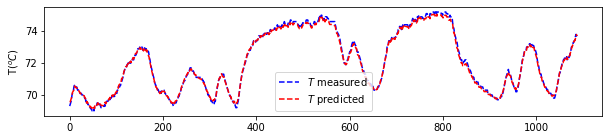

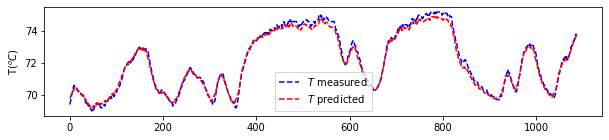

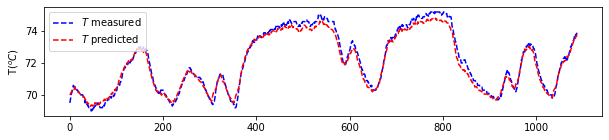

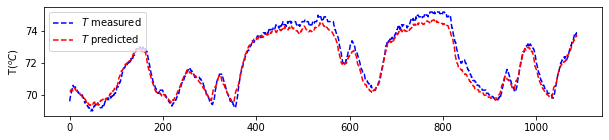

25808
1.3148203492164612


In [23]:
# Create Dataset and DataLoader objects
src_file = 'C:/Users/tln229/Downloads/Python/1. Building/data/HVAC_B90_102_exp_10m_20210424.csv'
n_train  = 512
train_ds = Data(src_file, start=0,       end=n_train)
test_ds  = Data(src_file, start=n_train, end=1600)

# Create network
device = torch.device("cpu")
net = Net().to(device)

# train
R2_test1, R2_test2, R2_test3, R2_test4, R2_full = train(net=net, max_epochs=50000, lr=0.01, patience=2000, train_ds=train_ds, test_ds=test_ds)

# plot
print("R2: ", eval(net, test_ds))
plot(net, test_ds, (10, 2))

max = np.argmax(R2_test1 + R2_test2 + R2_test3 + R2_test4)
print(max)
print(np.max(R2_test1 + R2_test2 + R2_test3 + R2_test4)/3)

In [24]:
# PATH = 'C:/Users/tln229/Downloads/Python/1. Building/0. Saved models/Tz (4-RNN).pt'
# torch.save(net, PATH)

In [25]:
np.argmax(R2_full)

25803

In [26]:
np.max(R2_full)

0.8429613514471065